<a href="https://colab.research.google.com/github/icy-mountain/resp_sounds/blob/main/cnn_detection_of_wheezes_and_crackles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Overview
Implementation of a convolutional neural network used to identify wheezes and crackles in an audio file which is fed Mel-Spectrograms as inputs. During processing, audio clips are copied to 5 second long buffers, and are split into multiple segments if necessary, with zero padding added to fill the rest of the buffer. During training, Mel-Spectrograms are transposed and wrapped around the time-axis to help allow the network to learn to identify features occurring at arbitrary times within the recording. Data augmentation was employed in the form of audio stretching (speeding up and down) as well as Vocal Tract Length Perturbation, especially for the scarcer '*wheeze*' and '*wheeze and crackles*' classes. A one hot data labelling scheme was chosen as earlier attempts at using a multi-label scheme using a Sigmoid output layer resulted in poor training results (which in hindsight may have been caused by an excessively high learning rate). Currently, both the '*wheeze*' and '*wheeze and crackles*' classes pose the greatest challenge in the area of classification, and frequently produce false negatives, as indicated by the poor recall scores.  Overall validation accuracy currently stands at roughly 70%.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import wave
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from IPython.display import Audio
import scipy
import librosa
import librosa.display
import tensorflow as tf
import tensorflow.keras as keras

from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
import cv2
import io
from google.colab.patches import cv2_imshow
import copy
%matplotlib inline
path = "/content/drive/My Drive/grad_article/respiratory-sound-database/Respiratory_Sound_Database/audio_and_txt_files/"
# tmp = os.listdir("/content/drive/My Drive/grad_article/respiratory-sound-database/Respiratory_Sound_Database/audio_and_txt_files/")
# seen = []
# wav_files = [i[0:-4] + '.wav' for i in tmp if i[0:-4] not in seen and not seen.append(i[1:-4])]
# wav_files = sorted(wav_files)
# print(f"seen:{len(seen)} wav_files:{len(wav_files)}") 

## make data

### Create patient data 

In [ ]:
path = '/content/drive/My Drive/grad_article/respiratory-sound-database/'
os.listdir(path)

['demographic_info.txt', 'Respiratory_Sound_Database']

In [ ]:
df_no_diagnosis = pd.read_csv(path + 'demographic_info.txt', names = 
                 ['Patient number', 'Age', 'Sex' , 'Adult BMI (kg/m2)', 'Child Weight (kg)' , 'Child Height (cm)'],
                 delimiter = ' ')
diagnosis = pd.read_csv(path + 'Respiratory_Sound_Database/patient_diagnosis.csv', names = ['Patient number', 'Diagnosis'])

In [ ]:
df =  df_no_diagnosis.join(diagnosis.set_index('Patient number'), on = 'Patient number', how = 'left')
df['Diagnosis'].value_counts()

COPD              64
Healthy           26
URTI              14
Bronchiectasis     7
Bronchiolitis      6
Pneumonia          6
LRTI               2
Asthma             1
Name: Diagnosis, dtype: int64

In [ ]:
df.to_csv('/content/drive/My Drive/grad_article/patient_data.csv')i

In [ ]:
# hoge = pd.read_csv('/content/drive/My Drive/grad_article/patient_data.csv', index_col=0)
hoge.head()

,Patient number,Age,Sex,Adult BMI (kg/m2),Child Weight (kg),Child Height (cm),Diagnosis
0,101,3.00,F,NaN,19.0,99.0,URTI
1,102,0.75,F,NaN,9.8,73.0,Healthy
2,103,70.00,F,33.00,NaN,NaN,Asthma
3,104,70.00,F,28.47,NaN,NaN,COPD
4,105,7.00,F,NaN,32.0,135.0,URTI


In [ ]:
# 19歳のデータにBMIが書かれていたので、18以上が大人設定かな
# df[(17.00 < df['Age']) & (df['Age'] < 22.00)]

# 19歳と21歳と以外はみんな40歳以上。そもそも年齢が微妙なので外しても良いかも
# df[(17 < df['Age']) & (df['Age'] < 66)].sort_values('Age')

True

In [ ]:
# 大人のデータでBMIデータがないのは222番のみ.他のカラムにはNanは無し
# df[(df['Age'] > 17) & (df['Adult BMI (kg/m2)'].isnull())]
# df[(df['Age'] > 17) & (df['Diagnosis'].isnull())]
df.dropna(subset=['Adult BMI (kg/m2)'])['Diagnosis'].value_counts()

COPD              62
Bronchiectasis     7
Pneumonia          5
Asthma             1
Name: Diagnosis, dtype: int64

In [ ]:
# Ageが18以上かつBMIのデータがあるIDを抽出
adult_id = df.dropna(subset=['Adult BMI (kg/m2)'])['Patient number'].values
adult_id

array([103, 104, 106, 107, 109, 110, 111, 112, 113, 114, 116, 117, 118,
       120, 122, 124, 128, 130, 132, 133, 134, 135, 138, 139, 140, 141,
       142, 145, 146, 147, 151, 154, 155, 156, 157, 158, 160, 162, 163,
       166, 168, 169, 170, 172, 174, 175, 176, 177, 178, 180, 181, 185,
       186, 189, 191, 192, 193, 195, 196, 198, 199, 200, 201, 203, 204,
       205, 207, 211, 212, 213, 215, 218, 219, 220, 221])

### Create resp data

In [ ]:
print(wav_files)

['160_1b3_Lr_mc_AKGC417L.wav', '160_1b3_Pl_mc_AKGC417L.wav', '160_1b4_Al_mc_AKGC417L.wav', '160_1b3_Pr_mc_AKGC417L.wav', '160_1b4_Ar_mc_AKGC417L.wav', '160_1b3_Tc_mc_AKGC417L.wav', '160_1b4_Lr_mc_AKGC417L.wav', '160_1b4_Al_mc_AKGC417L.wav', '160_1b4_Pl_mc_AKGC417L.wav', '160_1b4_Ar_mc_AKGC417L.wav', '160_1b4_Pr_mc_AKGC417L.wav', '160_1b4_Lr_mc_AKGC417L.wav', '160_1b4_Tc_mc_AKGC417L.wav', '160_1b4_Pl_mc_AKGC417L.wav', '160_2b3_Lr_mc_AKGC417L.wav', '160_1b4_Pr_mc_AKGC417L.wav', '160_2b4_Ar_mc_AKGC417L.wav', '160_1b4_Tc_mc_AKGC417L.wav', '160_2b4_Pl_mc_AKGC417L.wav', '160_2b4_Pr_mc_AKGC417L.wav', '160_2b3_Lr_mc_AKGC417L.wav', '160_2b4_Tc_mc_AKGC417L.wav', '160_2b4_Ar_mc_AKGC417L.wav', '161_1b1_Al_sc_Meditron.wav', '160_2b4_Pl_mc_AKGC417L.wav', '160_2b4_Pr_mc_AKGC417L.wav', '161_1b1_Pl_sc_Meditron.wav', '160_2b4_Tc_mc_AKGC417L.wav', '162_1b2_Al_mc_AKGC417L.wav', '162_1b2_Ar_mc_AKGC417L.wav', '161_1b1_Al_sc_Meditron.wav', '162_1b2_Ll_mc_AKGC417L.wav', '161_1b1_Pl_sc_Meditron.wav', '162_1b2_

In [ ]:
str_list = sorted(wav_files)
# print(str_list)
wav_files = str_list
wav_files

In [ ]:
3642 + 1864+886+506

6898

In [ ]:
size = 14000
names = np.full(size,"hoge", dtype=object)
starts = np.zeros((size),dtype=float)
ends = np.zeros((size),dtype=float)
crackles = np.zeros((size),dtype=int)
wheezes = np.zeros((size),dtype=int)
i = 0
for s in wav_files:
  name = s.split(".wav")[0]
  file = name + '.txt'
  with open(path + file, 'r') as f:
    # print(name)
    for line in f.readlines():
      l = line.split()
      names[i] = name
      starts[i] = float(l[0])
      ends[i] = float(l[1])
      crackles[i] = int(l[2])
      wheezes[i] = int(l[3])
      i += 1
# print(names)
# print(starts)
# print(ends)
# print(crackles)
# print(wheezes)

In [ ]:
true_names = names[names != 'hoge']
t_size = len(true_names)
# ends[ends != 0.0].shape

In [ ]:
hoge = pd.DataFrame()
hoge['Filename'] = true_names
hoge['Start'] = starts[:t_size]
hoge['End'] = ends[:t_size]
hoge['Crackles'] = crackles[:t_size]
hoge['Wheezes'] = wheezes[:t_size]

In [ ]:
# hoge = hoge.drop_duplicates().reset_index(drop=True)
no_ = np.zeros((len(hoge)), dtype=int)
cr = np.zeros((len(hoge)), dtype=int)
wh = np.zeros((len(hoge)), dtype=int)
cw = np.zeros((len(hoge)), dtype=int)
noise = np.zeros((len(hoge)), dtype=int)
for i, ele in enumerate(hoge.iterrows()):
  if ele[1]['Crackles'] and ele[1]['Wheezes']:
    cw[i] = 1
  elif ele[1]['Crackles'] and ele[1]['Wheezes'] == 0:
    cr[i] = 1
  elif ele[1]['Crackles'] == 0 and ele[1]['Wheezes']:
    wh[i] = 1
  elif ele[1]['Crackles'] == 0 and ele[1]['Wheezes'] == 0:
    no_[i] = 1
  if ele[1]['Crackles'] or ele[1]['Wheezes']:
    noise[i] = 1

In [ ]:
hoge['cr'] = cr
hoge['wh'] = wh
hoge['cw'] = cw
hoge['no'] = no_
hoge['noise'] = noise

In [ ]:
hoge[hoge['Crackles'] == 1][10:30]

In [ ]:
recording_anno.to_csv('/content/drive/My Drive/grad_article/recording_anno.csv')

In [ ]:
# recording_anno = recording_anno.astype({'Start':'float16', 'End':'float16', 'Crackles':'int8', 'Wheezes':'int8', 'cr':'int8', 'wh':'int8', 'cw':'int8', 'no':'int8', 'noise':'int8'})
recording_anno['wh']

0       0
1       0
2       0
3       0
4       0
       ..
6893    0
6894    0
6895    0
6896    0
6897    0
Name: wh, Length: 6898, dtype: int8

### その他の作業

In [ ]:
def Extract_Annotation_Data(file_name, root):
    tokens = file_name.split('_')
    recording_info = pd.DataFrame(data = [tokens], columns = ['Patient number', 'Recording index', 'Chest location','Acquisition mode','Recording equipment'])
    recording_annotations = pd.read_csv(os.path.join(root, file_name + '.txt'), names = ['Start', 'End', 'Crackles', 'Wheezes'], delimiter= '\t')
    return (recording_info, recording_annotations)

In [ ]:
i_list = []
rec_annotations = []
rec_annotations_dict = {}
# tmp_anno = pd.DataFrame([])
for s in filenames:
    (i,tmp_a) = Extract_Annotation_Data(s, root)
    i_list.append(i)
    rec_annotations.append(tmp_a)
    rec_annotations_dict[s] = tmp_a
    # tmp_a['Filename'] = s
    # tmp_anno = pd.concat([tmp_a,a])
# recording_info = pd.concat(i_list, axis = 0)
# recording_anno = tmp_anno.reindex(columns=['Filename', 'Start', 'End', 'Crackles', 'Wheezes'])

In [ ]:
# print(recording_info.head())
# recording_anno[recording_anno.duplicated()]
recording_anno[0:10]
# hoge = recording_anno.drop_duplicates()
# hoge = hoge.reset_index(drop=True)
# recording_anno[0:10]

,Filename,Start,End,Crackles,Wheezes,Labels,cr,wh,cw,no,noise
0,160_1b3_Tc_mc_AKGC417L,1.862,5.718,0,0,no,0,0,0,1,0
1,160_1b3_Tc_mc_AKGC417L,5.718,9.725,0,1,wh,0,1,0,0,1
2,160_1b3_Tc_mc_AKGC417L,9.725,13.614,0,1,wh,0,1,0,0,1
3,160_1b3_Tc_mc_AKGC417L,13.614,17.671,0,1,wh,0,1,0,0,1
4,160_1b3_Tc_mc_AKGC417L,17.671,19.541,0,0,no,0,0,0,1,0
5,160_1b3_Pr_mc_AKGC417L,1.862,5.718,1,1,cw,0,0,1,0,1
6,160_1b3_Pr_mc_AKGC417L,5.718,9.725,1,1,cw,0,0,1,0,1
7,160_1b3_Pr_mc_AKGC417L,9.725,13.614,1,1,cw,0,0,1,0,1
8,160_1b3_Pr_mc_AKGC417L,13.614,17.671,1,1,cw,0,0,1,0,1
9,160_1b3_Pr_mc_AKGC417L,17.671,19.541,1,0,cr,1,0,0,0,1


In [ ]:
# recording_info.to_csv('/content/drive/My Drive/grad_article/recording_info.csv')
# recording_anno.to_csv('/content/drive/My Drive/grad_article/recording_anno.csv')

In [ ]:
hoge = pd.read_csv('/content/drive/My Drive/grad_article/recording_anno.csv', index_col=0)
hoge

,Filename,Start,End,Crackles,Wheezes
0,160_1b3_Tc_mc_AKGC417L,1.862,5.718,0,0
1,160_1b3_Tc_mc_AKGC417L,5.718,9.725,0,1
2,160_1b3_Tc_mc_AKGC417L,9.725,13.614,0,1
3,160_1b3_Tc_mc_AKGC417L,13.614,17.671,0,1
4,160_1b3_Tc_mc_AKGC417L,17.671,19.541,0,0
...,...,...,...,...,...
3,160_1b4_Ar_mc_AKGC417L,15.401,19.841,1,1
0,160_1b4_Al_mc_AKGC417L,1.962,6.553,1,1
1,160_1b4_Al_mc_AKGC417L,6.553,11.160,1,1
2,160_1b4_Al_mc_AKGC417L,11.160,15.401,1,1


In [ ]:
recording_info['Patient number'] = recording_info['Patient number'].apply(lambda x: int(x))
is_adult = recording_info['Patient number'].apply(lambda x: x in adult_id)
#全wavデータ数は920  大人データは838(id222覗いたら835)
print(f"all data{len(recording_info)} adult data{len(recording_info[is_adult])}")

all data920 adult data835


In [ ]:
# 欠損なし
recording_info['Chest location'].value_counts()
# id130のデータが多い
recording_info['Patient number'].value_counts()

130    66
107    28
151    28
172    27
138    27
       ..
115     1
148     1
208     1
126     1
150     1
Name: Patient number, Length: 126, dtype: int64

In [ ]:
no_label_list = []
crack_list = []
wheeze_list = []
both_sym_list = []
filename_list = []
for f in filenames:
    d = rec_annotations_dict[f]
    no_labels = len(d[(d['Crackles'] == 0) & (d['Wheezes'] == 0)].index)
    n_crackles = len(d[(d['Crackles'] == 1) & (d['Wheezes'] == 0)].index)
    n_wheezes = len(d[(d['Crackles'] == 0) & (d['Wheezes'] == 1)].index)
    both_sym = len(d[(d['Crackles'] == 1) & (d['Wheezes'] == 1)].index)
    no_label_list.append(no_labels)
    crack_list.append(n_crackles)
    wheeze_list.append(n_wheezes)
    both_sym_list.append(both_sym)
    filename_list.append(f)

In [ ]:
file_crwh_counts = pd.DataFrame(data = {'filename':filename_list, 'no label':no_label_list, 'crackles only':crack_list, 'wheezes only':wheeze_list, 'crackles and wheezees':both_sym_list})

In [ ]:
# 欠損なし
file_crwh_counts.head()

,filename,no label,crackles only,wheezes only,crackles and wheezees
0,160_1b4_Al_mc_AKGC417L,0,0,0,4
1,160_1b4_Ar_mc_AKGC417L,0,0,2,2
2,160_1b4_Lr_mc_AKGC417L,0,0,4,0
3,160_1b4_Pl_mc_AKGC417L,0,0,3,1
4,160_1b4_Pr_mc_AKGC417L,0,2,0,2


In [ ]:
file_crwh_counts.to_csv('/content/drive/My Drive/grad_article/file_crwh_counts.csv')

In [ ]:
hoge = pd.read_csv('/content/drive/My Drive/grad_article/file_crwh_counts.csv', index_col = 0)
hoge.head()i

In [ ]:
#大人データを抽出してみる
def extract_ad(df_series):
  ad_list = []
  for i in df_series:
    ad_list.append(True if int(i[0:3]) in adult_id else False)
  return pd.Series(ad_list)

# file_crwh_counts
file_crwh_counts[extract_ad(file_crwh_counts["filename"])]
# type(func(file_crwh_counts["filename"]))

,filename,no label,crackles only,wheezes only,crackles and wheezees
0,160_1b4_Al_mc_AKGC417L,0,0,0,4
1,160_1b4_Ar_mc_AKGC417L,0,0,2,2
2,160_1b4_Lr_mc_AKGC417L,0,0,4,0
3,160_1b4_Pl_mc_AKGC417L,0,0,3,1
4,160_1b4_Pr_mc_AKGC417L,0,2,0,2
...,...,...,...,...,...
915,160_1b2_Tc_mc_AKGC417L,1,0,1,0
916,160_1b3_Al_mc_AKGC417L,1,0,3,1
917,160_1b3_Pl_mc_AKGC417L,1,0,2,2
918,160_1b3_Pr_mc_AKGC417L,0,1,0,4


## sound analy

### Distribution of data classes

In [ ]:
w_labels = file_crwh_counts[(file_crwh_counts['crackles only'] != 0) | (file_crwh_counts['wheezes only'] != 0) | (file_crwh_counts['crackles and wheezees'] != 0)]
file_crwh_counts.sum()

KeyError: ignored

### Distribution of respiratory cycle lengths

longest cycle:16.163
shortest cycle:0.1999999999999993
Fraction of samples less than 6 seconds:0.9827611183543387
CPU times: user 61.5 ms, sys: 1.83 ms, total: 63.3 ms
Wall time: 79.4 ms


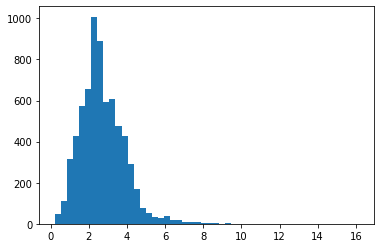

In [ ]:
%%time
#全体の肺周期
duration_list = recording_anno['End'] - recording_anno['Start']
plt.hist(duration_list, bins = 50)
print('longest cycle:{}'.format(max(duration_list)))
print('shortest cycle:{}'.format(min(duration_list)))
threshold = 6
print(f'Fraction of samples less than {threshold} seconds:{np.sum(duration_list < threshold)/len(duration_list)}')

longest cycle:8.736000000000004
shortest cycle:0.3670000000000009
Fraction of samples less than 6 seconds:0.9924892703862661


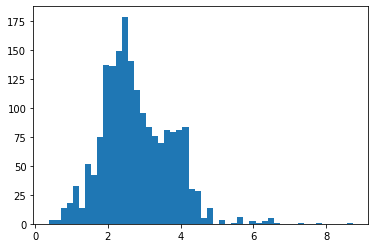

In [ ]:
#crの肺周期
duration_list = cr_files['End'] - cr_files['Start']
plt.hist(duration_list, bins = 50)
print('longest cycle:{}'.format(max(duration_list)))
print('shortest cycle:{}'.format(min(duration_list)))
threshold = 6
print(f'Fraction of samples less than {threshold} seconds:{np.sum(duration_list < threshold)/len(duration_list)}')

longest cycle:9.217
shortest cycle:0.228
Fraction of samples less than 6 seconds:0.9910011248593926


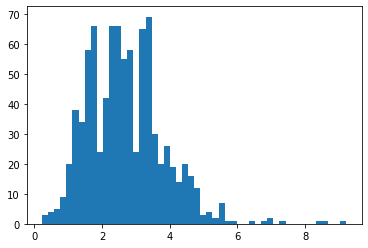

In [ ]:
#whの肺周期
duration_list = wh_files['End'] - wh_files['Start']
plt.hist(duration_list, bins = 50)
print('longest cycle:{}'.format(max(duration_list)))
print('shortest cycle:{}'.format(min(duration_list)))
threshold = 6
print(f'Fraction of samples less than {threshold} seconds:{np.sum(duration_list < threshold)/len(duration_list)}')

longest cycle:16.163
shortest cycle:0.1999999999999993
Fraction of samples less than 6 seconds:0.9750274423710209


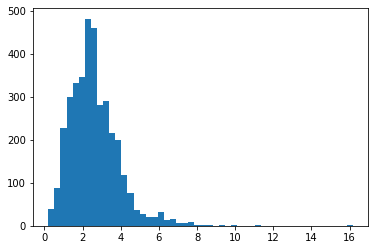

In [ ]:
#noの肺周期
duration_list = no_files['End'] - no_files['Start']
plt.hist(duration_list, bins = 50)
print('longest cycle:{}'.format(max(duration_list)))
print('shortest cycle:{}'.format(min(duration_list)))
threshold = 6
print(f'Fraction of samples less than {threshold} seconds:{np.sum(duration_list < threshold)/len(duration_list)}')

longest cycle:8.5917
shortest cycle:0.570999999999998
Fraction of samples less than 6 seconds:0.9881422924901185


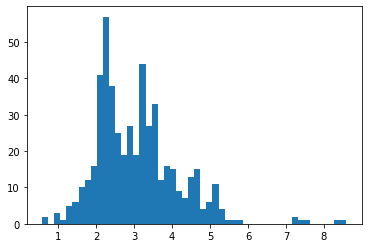

In [ ]:
#cwの肺周期
duration_list = cw_files['End'] - cw_files['Start']
plt.hist(duration_list, bins = 50)
print('longest cycle:{}'.format(max(duration_list)))
print('shortest cycle:{}'.format(min(duration_list)))
threshold = 6
print(f'Fraction of samples less than {threshold} seconds:{np.sum(duration_list < threshold)/len(duration_list)}')

## make functions

### その他の作業

In [ ]:
def preEmphasis(signal, p):
    """プリエンファシスフィルタ"""
    # 係数 (1.0, -p) のFIRフィルタを作成
    return scipy.signal.lfilter([1.0, -p], 1, signal)

(882000,)
20
Filename    101_1b1_Pr_sc_Meditron
Start                      1.26367
End                        3.42188
Crackles                         0
Wheezes                          0
cr                               0
wh                               0
cw                               0
no                               1
noise                            0
Name: 13, dtype: object
2.158203125
95178


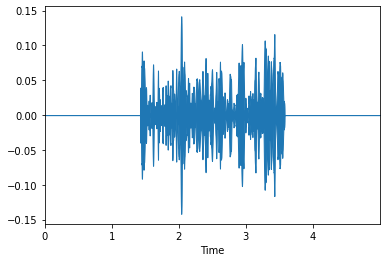

In [ ]:
#5秒
import math
data, sr = 0 , 44100
g_data = np.zeros((sr * 5))
cycle_idx = 0
for ele in no_files[13:].iterrows():
  data, sr = librosa.load(path + ele[1]["Filename"] + ".wav", sr = sr)
  # data = data[]
  print(data.shape)
  print(len(data) // sr)
  print(ele[1])
  span = ele[1][2] - ele[1][1] 
  print(span)
  cycle_len = math.ceil(span * sr) + 1
  begin = math.ceil(ele[1][1]* sr) + 1
  print(cycle_len)
  padd = len(g_data) - cycle_len
  if padd < 0:
    break
  g_data[padd//2:-padd//2] = np.copy(data[begin : begin + cycle_len])
  break
# g_data = preEmphasis(g_data, 0.97)
librosa.display.waveplot(g_data, sr)
Audio(g_data,rate=sr, autoplay=True)

In [ ]:
#やばい音
# 158_2p2_Ar_mc_AKGC417L cr_files index10~
data, sr = librosa.load(path + "158_2p2_Ar_mc_AKGC417L" +".wav", sr = sr)
Audio(data,rate=sr, autoplay=True)

In [ ]:
F =  np.fft.fft(g_data)
F

array([ 0.00000000e+00+0.00000000e+00j,  1.36413241e-04+5.04607674e-05j,
       -3.15132888e-05+9.15772220e-04j, ...,
       -3.82817178e-04+2.01632082e-04j, -3.15132888e-05-9.15772220e-04j,
        1.36413241e-04-5.04607674e-05j])

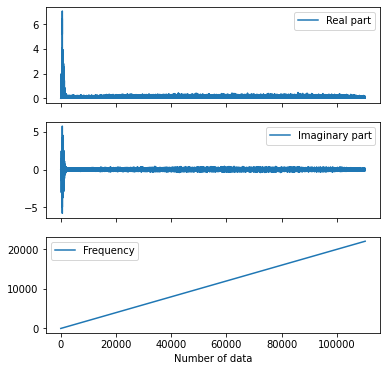

In [ ]:
# 離散フーリエ変換
F = np.fft.fft(g_data) # 変換結果
N = len(F)
freq = np.fft.fftfreq(N, d=1./sr) # 周波数
fig, ax = plt.subplots(nrows=3, sharex=True, figsize=(6,6))
# ax[0].scatter(freq[:N//2], abs(F[:N//2]), label="Real part", s=1)
# ax[0].legend()
ax[0].plot(abs(F.real[:N // 2]), label = "Real part")
ax[0].legend()
ax[1].plot(F.imag[:N // 2], label="Imaginary part")
ax[1].legend()
ax[2].plot(freq[:N//2], label="Frequency")
ax[2].legend()
ax[2].set_xlabel("Number of data")
plt.show()

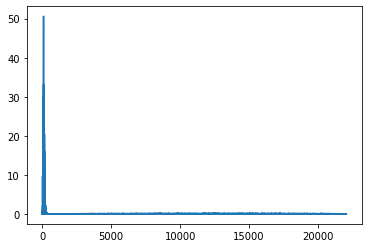

In [ ]:
F_pow = np.abs(F) ** 2
plt.plot(freq[:N//2], F_pow[:N//2])

(128, 862)


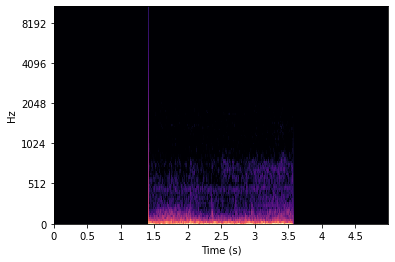

In [ ]:
# mel_spectrogram
# specshow関数だが、y_axis=melは22050Hzに合わせてy軸を描画するということなので、sr=44100Hzだと実際よりも低く周波数が表示されてしまう。
# sr = 22050で1024以上を増幅しようかなあ
n_fft = 1024
hop_len = n_fft // 4
mel_spect = librosa.feature.melspectrogram(y=g_data, sr=sr/2, n_fft=n_fft, hop_length = hop_len)
mel_spect = librosa.power_to_db(mel_spect, ref=np.max)
librosa.display.specshow(mel_spect[0:,0:], y_axis='mel', x_axis='s', x_coords=np.arange(0, 5, 5./len(mel_spect[0])))#, fmax=8000)
print(mel_spect[:, :].shape)
# mel_spect[50:51, 200:300]

In [ ]:
!pip install PySoundFile

In [ ]:
import soundfile as sf
from IPython.display import Audio
import librosa
import librosa.display

In [ ]:
tmp = os.listdir("/content/drive/My Drive/grad_article/respiratory-sound-database/Respiratory_Sound_Database/audio_and_txt_files/")
seen = []
wav_files = [i[0:-4] + '.wav' for i in tmp if i[0:-4] not in seen and not seen.append(i[1:-4])]
print(f"seen:{len(seen)} wav_files:{len(wav_files)}") 

In [ ]:
# 24bitのファイルの数と、マルチチャンネルを確認
# 次元が1以外のものは無かった。マルチチャンネルとは・・？
path = "/content/drive/My Drive/grad_article/respiratory-sound-database/Respiratory_Sound_Database/audio_and_txt_files/"
mc = [i for i in wav_files if "mc" in i]
print(len(mc))
for i , name in enumerate(mc):
  data, sr = librosa.load(path + name, sr = 44100)
  # print(f"name:{name} dim:{data.ndim}")
  if data.ndim != 1:
    print(f"dim != 1 file:{name}")
  # if i == 100:
  #   break

In [ ]:
import soundfile as sf
from IPython.display import Audio

path = "/content/drive/My Drive/grad_article/respiratory-sound-database/Respiratory_Sound_Database/audio_and_txt_files/"

def display_wave(num):
  for i,name in enumerate(wav_files):
    data ,sr = sf.read(path + name, dtype="float64")
    print(f'\n filename:{name} data_shape:{data.shape} sr:{sr}')
    time = np.arange(0,len(data))/sr
    plt.plot(time, data)
    plt.show()
    plt.close()   
    Audio(data,rate=sr, autoplay=False)
    if i == num:
      return 
display_wave(4)

In [ ]:
def graph_spectrogram(wav_file):
    data, rate = sf.read(wav_file, dtype="int32")
    nfft = 512 #200 # Length of each window segment
    fs = rate/2 #8000 # Sampling frequencies
    noverlap = 256 #120 # Overlap between windows
    nchannels = data.ndim
    if nchannels == 1:
        pxx, freqs, bins, im = plt.specgram(data, nfft, fs, noverlap = noverlap)
    elif nchannels == 2:
        pxx, freqs, bins, im = plt.specgram(data[:,0], nfft, fs, noverlap = noverlap)
    return pxx
for i , name in enumerate(wav_files):
  graph_spectrogram(path+name)
  plt.show()
  if i == 4:
    break


In [ ]:
# multi channel なのにシングルsoundfileだと全部シングル？
path = "/content/drive/My Drive/grad_article/respiratory-sound-database/Respiratory_Sound_Database/audio_and_txt_files/"
for i in wav_files:
  data, sr = read_wav(i)

In [ ]:
# librosaを試す
import librosa
import librosa.display

path = "/content/drive/My Drive/grad_article/respiratory-sound-database/Respiratory_Sound_Database/audio_and_txt_files/"
data, sr = 0, 0
for i, name in enumerate(wav_files):
  data, sr = librosa.load(path + name, sr = 44100)
  print(f'\n filename:{name} data_shape:{data.shape} sr:{sr}')
  librosa.display.waveplot(data, sr)
  n_fft = 2048
  # win_len = 1024
  # hop_len = win_len // 4
  ft = np.abs(librosa.stft(data))
  plt.plot(ft);
  plt.title('Spectrum');
  plt.xlabel('Frequency Bin');
  plt.ylabel('Amplitude');
  plt.show()
  print(ft.shape)
  print(ft)
  # D = librosa.stft(data)  # STFT
  # S, phase = librosa.magphase(D)  # 複素数を強度と位相へ変換
  # Sdb = librosa.amplitude_to_db(S, ref = np.max)  # 強度をdb単位へ変換 refで、dbを相対尺度にしている
  # librosa.display.specshow(Sdb, sr=sr, x_axis='time', y_axis='log')
  # plt.colorbar(format='%+2.0f dB');

  # mel_spect = librosa.feature.melspectrogram(y=data, sr=sr, n_fft=n_fft, hop_length = hop_len, )
  # mel_spect = librosa.power_to_db(mel_spect, ref=np.max)
  # librosa.display.specshow(mel_spect, y_axis='mel', x_axis='time', fmax=8000)
  # plt.title('Mel Spectrogram');
  # plt.colorbar(format='%+2.0f dB');
  if i == 0:
    break
# Audio(data,rate=sr, autoplay=True)

In [ ]:
librosa.display.waveplot(data, sr)

In [ ]:
data, sr = librosa.load(path + wav_files[111], sr = 44100)
F = np.fft.fft(data)
amp = np.abs(F)
N = len(data)  # データ数
amp_normal = amp / (N / 2)
amp_normal[0] /= 2 
freq = np.linspace(0, sr, sr)
print(freq)
plt.xlabel('frequency(Hz)')
plt.ylabel('amplitude')
plt.plot(freq[:sr // 2 + 1], amp_normal[:sr // 2 + 1]) # ナイキスト定数まで表示
plt.grid()
plt.tight_layout()
plt.show()

In [ ]:
# 公式ドキュメントの例
import librosa
import librosa.display

path = "/content/drive/My Drive/grad_article/respiratory-sound-database/Respiratory_Sound_Database/audio_and_txt_files/"
data, sr = 0, 0
for i, name in enumerate(wav_files):
  data, sr = librosa.load(path + name, sr = 22050)
  print(f'\n filename:{name} data_shape:{data.shape} sr:{sr}')
  S = np.abs(librosa.stft(data))
  librosa.display.specshow(librosa.amplitude_to_db(S,
                                                   ref=np.max),
                                                   y_axis='log', x_axis='time')
  plt.title('Power spectrogram')
  plt.colorbar(format="%+2.0f dB")
  if i == 0:
    break

In [ ]:
recording_anno[0:1]

,Filename,Start,End,Crackles,Wheezes,cr,wh,cw,no,noise
0,101_1b1_Al_sc_Meditron,0.036011,0.579102,0,0,0,0,0,1,0


In [ ]:
patient_data['Patient number'].values.dtype

dtype('int8')

In [ ]:
patient_data

,Patient number,Age,Sex,Adult BMI (kg/m2),Child Weight (kg),Child Height (cm),Diagnosis
0,101,3.00,F,NaN,19.0,99.0,URTI
1,102,0.75,F,NaN,9.8,73.0,Healthy
2,103,70.00,F,33.00,NaN,NaN,Asthma
3,104,70.00,F,28.47,NaN,NaN,COPD
4,105,7.00,F,NaN,32.0,135.0,URTI
...,...,...,...,...,...,...,...
121,222,60.00,M,NaN,NaN,NaN,COPD
122,223,NaN,NaN,NaN,NaN,NaN,COPD
123,224,10.00,F,NaN,32.3,143.0,Healthy
124,225,0.83,M,NaN,7.8,74.0,Healthy


### 上で作成した各種データフレームの読み込み

In [ ]:
# patient_data.csv:患者の背景データ
# recording_info.csv:ファイル名を解析したデータ
# recording_anno.csv: ファイル内を解析したデータ
# file_crwh_counts.csv:そのファイルでどれだけcrackling,whistlingが起こったか
patient_data = pd.read_csv("/content/drive/My Drive/grad_article/data_csv/patient_data.csv", index_col=0)
patient_data = patient_data.astype({'Patient number':'uint8'})
recording_info = pd.read_csv("/content/drive/My Drive/grad_article/data_csv/recording_info.csv", index_col=0)
recording_anno = pd.read_csv("/content/drive/My Drive/grad_article/data_csv/recording_anno.csv", index_col=0)
recording_anno = recording_anno.astype({'Start':'float16', 'End':'float16', 'Crackles':'uint8', 'Wheezes':'uint8', 'cr':'uint8', 'wh':'uint8', 'cw':'uint8', 'no':'uint8', 'noise':'uint8'})
file_crwh_counts = pd.read_csv("/content/drive/My Drive/grad_article/data_csv/file_crwh_counts.csv", index_col=0)

In [ ]:
# それぞれの音声のみ含むファイル抽出
cr_files = recording_anno[(recording_anno["Crackles"] == 1) & (recording_anno["Wheezes"] == 0)]
wh_files = recording_anno[(recording_anno["Crackles"] == 0) & (recording_anno["Wheezes"] == 1)]
no_files = recording_anno[(recording_anno["Crackles"] == 0) & (recording_anno["Wheezes"] == 0)]
cw_files = recording_anno[(recording_anno["Crackles"] == 1) & (recording_anno["Wheezes"] == 1)]
print(f"{len(cr_files)} {len(wh_files)} {len(no_files)} {len(cw_files)}")

1864 886 3642 506


In [ ]:
# new_file.to_csv('/content/drive/My Drive/grad_article/recording_anno.csv')

In [ ]:
# recording_anno[recording_anno["Filename"] == "158_2p2_Ar_mc_AKGC417L"]
# new_file = recording_anno.reset_index(drop=True)
# new_file
for i in recording_anno[recording_anno["Filename"] == "226_1b1_Pl_sc_LittC2SE"].index:
  print(type(i))
  break
print(type(recording_anno[recording_anno["Filename"] == "226_1b1_Pl_sc_LittC2SE"].index[0]))

<class 'int'>
<class 'numpy.int64'>


### Utility functions for reading .wav files (especially pesky 24bit .wav)

In [ ]:
import wave
import math
import scipy.io.wavfile as wf
#wave file reader

#Will resample all files to the target sample rate and produce a 32bit float array
def read_wav_file(str_filename, target_rate):
    wav = wave.open(str_filename, mode = 'r')
    (sample_rate, data) = extract2FloatArr(wav,str_filename)
    
    if (sample_rate != target_rate):
        ( _ , data) = resample(sample_rate, data, target_rate)
        
    wav.close()
    return (target_rate, data.astype(np.float32))

def resample(current_rate, data, target_rate):
    x_original = np.linspace(0,100,len(data))
    x_resampled = np.linspace(0,100, int(len(data) * (target_rate / current_rate)))
    resampled = np.interp(x_resampled, x_original, data)
    return (target_rate, resampled.astype(np.float32))

# -> (sample_rate, data)
def extract2FloatArr(lp_wave, str_filename):
    (bps, channels) = bitrate_channels(lp_wave)
    
    if bps in [1,2,4]:
        (rate, data) = wf.read(str_filename)
        divisor_dict = {1:255, 2:32768}
        if bps in [1,2]:
            divisor = divisor_dict[bps]
            data = np.divide(data, float(divisor)) #clamp to [0.0,1.0]        
        return (rate, data)
    
    elif bps == 3: 
        #24bpp wave
        return read24bitwave(lp_wave)
    
    else:
        raise Exception('Unrecognized wave format: {} bytes per sample'.format(bps))
        
#Note: This function truncates the 24 bit samples to 16 bits of precision
#Reads a wave object returned by the wave.read() method
#Returns the sample rate, as well as the audio in the form of a 32 bit float numpy array
#(sample_rate:float, audio_data: float[])
def read24bitwave(lp_wave):
    nFrames = lp_wave.getnframes()
    buf = lp_wave.readframes(nFrames)
    reshaped = np.frombuffer(buf, np.int8).reshape(nFrames,-1)
    short_output = np.empty((nFrames, 2), dtype = np.int8)
    short_output[:,:] = reshaped[:, -2:]
    short_output = short_output.view(np.int16)
    return (lp_wave.getframerate(), np.divide(short_output, 32768).reshape(-1))  #return numpy array to save memory via array slicing

def bitrate_channels(lp_wave):
    bps = (lp_wave.getsampwidth() / lp_wave.getnchannels()) #bytes per sample
    return (bps, lp_wave.getnchannels())

def slice_data(start, end, raw_data,  sample_rate):
    max_ind = len(raw_data) 
    start_ind = min(int(start * sample_rate), max_ind)
    end_ind = min(int(end * sample_rate), max_ind)
    return raw_data[start_ind: end_ind]

### sample2melspect に対してアレコレ


In [ ]:
recording_anno[20:30]

,Filename,Start,End,Crackles,Wheezes,cr,wh,cw,no,noise
20,101_1b1_Pr_sc_Meditron,15.179688,17.203125,0,0,0,0,0,1,0
21,101_1b1_Pr_sc_Meditron,17.203125,19.171875,0,0,0,0,0,1,0
22,101_1b1_Pr_sc_Meditron,19.171875,19.937500,0,0,0,0,0,1,0
23,102_1b1_Ar_sc_Meditron,0.263916,1.736328,0,0,0,0,0,1,0
24,102_1b1_Ar_sc_Meditron,1.736328,3.292969,0,0,0,0,0,1,0
25,102_1b1_Ar_sc_Meditron,3.292969,5.308594,0,0,0,0,0,1,0
26,102_1b1_Ar_sc_Meditron,5.308594,6.636719,0,0,0,0,0,1,0
27,102_1b1_Ar_sc_Meditron,6.636719,8.039062,0,0,0,0,0,1,0
28,102_1b1_Ar_sc_Meditron,8.039062,9.609375,0,0,0,0,0,1,0
29,102_1b1_Ar_sc_Meditron,9.609375,11.039062,0,0,0,0,0,1,0


In [ ]:
file = "102_1b1_Ar_sc_Meditron"
target = recording_anno[recording_anno['Filename'] == file]
target_rate = 22000
c_info = get_sound_samples(target, file, path, target_rate)
c_info = split_and_pad(c_info[1], 5, target_rate)
# print(c_info[0])
vtlp_alpha = [0.9,1.1]
vtlp_upper_freq = [3200,3800]
vtlp_params = (1.1, 3500)

rtn = sample2MelSpectrum(c_info[0], target_rate, 50, vtlp_params=vtlp_params, classes=2)
# no_rtn = sample2MelSpectrum(c_info[0], target_rate, 50, vtlp_params=None, classes=2)


# rtn[0].shape

copy[-diff:].shape:(12821,) source[0:diff]:(12821,)


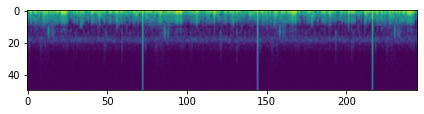

In [ ]:
plt.figure(figsize = (7,7))
# plt.subplot(3,1,1)
plt.imshow(rtn[0].reshape(rtn[0].shape[0], rtn[0].shape[1]))
# plt.title('No VTLP')

Text(0.5, 1.0, 'diff')

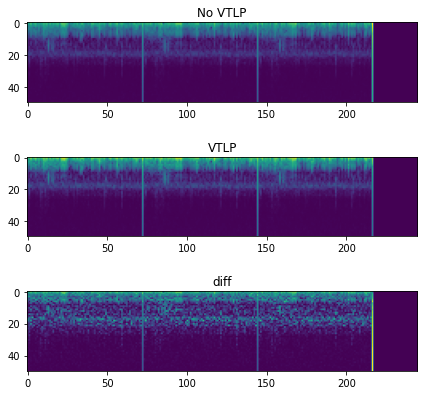

In [ ]:
plt.figure(figsize = (7,7))
plt.subplot(3,1,1)
plt.imshow(no_rtn[0].reshape(no_rtn[0].shape[0], no_rtn[0].shape[1]))
plt.title('No VTLP')

plt.subplot(3,1,2)
plt.imshow(rtn[0].reshape(rtn[0].shape[0], rtn[0].shape[1]))
plt.title('VTLP')

diff = abs(no_rtn[0] - rtn[0])
plt.subplot(3,1,3)
plt.imshow(diff.reshape(diff.shape[0], diff.shape[1]))
plt.title('diff')


In [ ]:
rtn[0]

(128, 430)


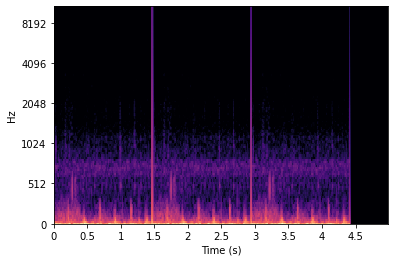

In [ ]:
sr = target_rate
n_fft = 1024
hop_len = n_fft // 4
mel_spect = librosa.feature.melspectrogram(y=c_info[0][0], sr=sr/2, n_fft=n_fft, hop_length = hop_len)
mel_spect = librosa.power_to_db(mel_spect, ref=np.max)
librosa.display.specshow(mel_spect[0:,0:], y_axis='mel', x_axis='s', x_coords=np.arange(0, 5, 5./len(mel_spect[0])))#, fmax=8000)
print(mel_spect[:, :].shape)

### Mel spectrogram implementation (With VTLP)

In [ ]:
def preEmphasis(signal, p):
    """プリエンファシスフィルタ"""
    # 係数 (1.0, -p) のFIRフィルタを作成
    return scipy.signal.lfilter([1.0, -p], 1, signal)

In [ ]:
import scipy.signal

#vtlp_params = (alpha, f_high) 
def sample2MelSpectrum(cycle_info, sample_rate, n_filters, vtlp_params,classes=4):
    n_rows = 175 # 7500 cutoff
    n_window = 512 #~25 ms window
    # (f, t, Sxx) = scipy.signal.spectrogram(preEmphasis(cycle_info[0],0.97),fs = sample_rate, nfft= n_window, nperseg=n_window)
    (f, t, Sxx) = scipy.signal.spectrogram(cycle_info[0],fs = sample_rate, nfft= n_window, nperseg=n_window)
    # plt.figure(figsize = (7,7))
    # plt.axis("off")
    # plt.pcolormesh(t, f,np.log10(Sxx + 10e-15))
    # plt.pcolormesh(t, Freq2Mel(f),np.log10(Sxx + 10e-15))
    Sxx = Sxx[:n_rows,:].astype(np.float32) #sift out coefficients above 7500hz, Sxx has 196 columns
    mel_log = FFT2MelSpectrogram(f[:n_rows], Sxx, sample_rate, n_filters, vtlp_params)[1]
    mel_min = np.min(mel_log)
    mel_max = np.max(mel_log)
    diff = mel_max - mel_min
    norm_mel_log = (mel_log - mel_min) / diff if (diff > 0) else np.zeros(shape = (n_filters,Sxx.shape[1]))

    # print(f"t shape {t.shape}")
    # print(f"f shape{f.shape}")
    # print(f"Sxx shape {Sxx.shape}")
    # plt.imshow(Sxx)
    # plt.imshow(np.log10(Sxx + 10e-15))
    # plt.imshow(norm_mel_log)
    if (diff == 0):
        print('Error: sample data is completely empty')
    labels = [cycle_info[1], cycle_info[2]] #crackles, wheezes flags
    return (np.reshape(norm_mel_log, (n_filters,Sxx.shape[1],1)).astype(np.float32), # 196x64x1 matrix
            label2onehot(labels,classes)) 
        
def Freq2Mel(freq):
    return 1127 * np.log(1 + freq / 700)

def Mel2Freq(mel):
    exponents = mel / 1127
    return 700 * (np.exp(exponents) - 1)

#Tased on Jaitly & Hinton(2013)
#Takes an array of the original mel spaced frequencies and returns a warped version of them
def VTLP_shift(mel_freq, alpha, f_high, sample_rate):
    nyquist_f = sample_rate / 2
    warp_factor = min(alpha, 1)
    threshold_freq = f_high * warp_factor / alpha
    lower = mel_freq * alpha
    higher = nyquist_f - (nyquist_f - mel_freq) * ((nyquist_f - f_high * warp_factor) / (nyquist_f - f_high * (warp_factor / alpha)))
    
    warped_mel = np.where(mel_freq <= threshold_freq, lower, higher)
    return warped_mel.astype(np.float32)

#mel_space_freq: the mel frequencies (HZ) of the filter banks, in addition to the two maximum and minimum frequency values
#fft_bin_frequencies: the bin freqencies of the FFT output
#Generates a 2d numpy array, with each row containing each filter bank
def GenerateMelFilterBanks(mel_space_freq, fft_bin_frequencies):
    n_filters = len(mel_space_freq) - 2
    coeff = []
    #Triangular filter windows
    #ripped from http://practicalcryptography.com/miscellaneous/machine-learning/guide-mel-frequency-cepstral-coefficients-mfccs/
    for mel_index in range(n_filters):
        m = int(mel_index + 1)
        filter_bank = []
        for f in fft_bin_frequencies:
            if (f < mel_space_freq[m-1]):
                hm = 0
            elif (f < mel_space_freq[m]):
                hm = (f - mel_space_freq[m-1]) / (mel_space_freq[m] - mel_space_freq[m-1])
            elif (f < mel_space_freq[m + 1]):
                hm = (mel_space_freq[m+1] - f) / (mel_space_freq[m + 1] - mel_space_freq[m])
            else:
                hm = 0
            filter_bank.append(hm)
        coeff.append(filter_bank)
    # print(f"filter shape:{np.array(coeff).shape}")
    # f = np.linspace(0,22000/2,(175//2)+1)
    # plt.plot(coeff[25])
    return np.array(coeff, dtype = np.float32)
        
#Transform spectrogram into mel spectrogram -> (frequencies, spectrum)
#vtlp_params = (alpha, f_high), vtlp will not be applied if set to None
def FFT2MelSpectrogram(f, Sxx, sample_rate, n_filterbanks, vtlp_params = None):
    (max_mel, min_mel)  = (Freq2Mel(max(f)), Freq2Mel(min(f)))
    mel_bins = np.linspace(min_mel, max_mel, num = (n_filterbanks + 2))
    #Convert mel_bins to corresponding frequencies in hz
    mel_freq = Mel2Freq(mel_bins)
    
    if (vtlp_params is None):
        filter_banks = GenerateMelFilterBanks(mel_freq, f)
    else:
        #Apply VTLP
        (alpha, f_high) = vtlp_params
        warped_mel = VTLP_shift(mel_freq, alpha, f_high, sample_rate)
        filter_banks = GenerateMelFilterBanks(warped_mel, f)
        
    mel_spectrum = np.matmul(filter_banks, Sxx)
    # print(f"mel_spectrum {mel_spectrum.shape} banks shape:{filter_banks.shape} Sxx shape:{Sxx.shape} ")
    return (mel_freq[1:-1], np.log10(mel_spectrum  + float(10e-12)))
    
#labels proved too difficult to train (model keep convergining to statistical mean)
#Flattened to onehot labels since the number of combinations is very low
def label2onehot(c_w_flags,classes=4):
    c = c_w_flags[0]
    w = c_w_flags[1]
    if classes > 2:
      if ((c == False) & (w == False)):
          return [1,0,0,0]
      elif ((c == True) & (w == False)):
          return [0,1,0,0]
      elif ((c == False) & (w == True)):
          return [0,0,1,0]
      else:
          return [0,0,0,1]
    else:
      if c == False and w == False:
        return 0
      else:
        return 1

### Data preparation utility functions

In [ ]:
#Used to split each individual sound file into separate sound clips containing one respiratory cycle each
#output: [filename, (sample_data:np.array, start:float, end:float, crackles:bool(float), wheezes:bool(float)) (...) ]
def get_sound_samples(recording_annotations, file_name, root, sample_rate):
    sample_data = [file_name]
    (rate, data) = read_wav_file(os.path.join(root, file_name + '.wav'), sample_rate)
    
    for i in recording_annotations.index:
        row = recording_annotations.loc[i]
        start = row['Start']
        end = row['End']
        crackles = row['Crackles']
        wheezes = row['Wheezes']
        rec_anno_idx = i
        audio_chunk = slice_data(start, end, data, rate)
        sample_data.append((audio_chunk,crackles,wheezes,rec_anno_idx))
    return sample_data

def myget_sound_samples(recording_annotations, file_name, root, sample_rate):
    no = []
    cr = []
    wh = []
    cw = []
    (rate, data) = read_wav_file(os.path.join(root, file_name + '.wav'), sample_rate)
    
    for i in recording_annotations.index:
        row = recording_annotations.loc[i]
        start = row['Start']
        end = row['End']
        crackles = row['Crackles']
        wheezes = row['Wheezes']
        audio_chunk = slice_data(start, end, data, rate)
        if not crackles and not wheezes:
          no.append(audio_chunk)
        if crackles and not wheezes:
          cr.append(audio_chunk)
        if not crackles and wheezes:
          wh.append(audio_chunk)
        if crackles and wheezes:
          cw.append(audio_chunk)
    return no, cr, wh, cw

#Fits each respiratory cycle into a fixed length audio clip, splits may be performed and zero padding is added if necessary
#original:(arr,c,w) -> output:[(arr,c,w),(arr,c,w)]
def split_and_pad(original, desiredLength, sampleRate):
    output_buffer_length = int(desiredLength * sampleRate)
    soundclip = original[0]
    n_samples = len(soundclip)
    total_length = n_samples / sampleRate #length of cycle in seconds
    n_slices = int(math.ceil(total_length / desiredLength)) #get the minimum number of slices needed
    samples_per_slice = n_samples // n_slices
    src_start = 0 #Staring index of the samples to copy from the original buffer
    output = [] #Holds the resultant slices
    for i in range(n_slices):
        src_end = min(src_start + samples_per_slice, n_samples)
        length = src_end - src_start
        copy = generate_padded_samples(soundclip[src_start:src_end], output_buffer_length)
        output.append((copy, original[1], original[2]))
        src_start += length
    return output

def generate_padded_samples(source, output_length):
    copy = np.zeros(output_length, dtype = np.float32)
    src_length = len(source)
    frac = src_length / output_length
    cursor = 1
    if (frac < 0.5):
        cursor = 0
        #tile forward sounds to fill empty space
        while (cursor + src_length) < output_length:
            copy[cursor:(cursor + src_length)] = source[:]
            cursor += src_length
    else:
        copy[:src_length] = source[:]
    minus = src_length if cursor == 1 else cursor
    diff = output_length - minus
    if copy[-diff:].shape != source[0:diff].shape:
      print(f"diff:{diff}")
      print(f"copy[-diff:].shape:{copy[-diff:].shape} source[0:diff]:{source[0:diff].shape}")
    if diff != 0:
      copy[-diff:] = source[0:diff]
    return copy

### Data augmentation
 Two basic forms employed : audio stretching (speeding up or down)  as well as Vocal Tract Length perturbation

In [ ]:
#Creates a copy of each time slice, but stretches or contracts it by a random amount
def gen_time_stretch(original, sample_rate, max_percent_change):
    stretch_amount = 1 + np.random.uniform(-1,1) * (max_percent_change / 100)
    (_, stretched) = resample(sample_rate, original, int(sample_rate * stretch_amount)) 
    return stretched

#Same as above, but applies it to a list of samples
def augment_list(audio_with_labels, sample_rate, percent_change, n_repeats):
    augmented_samples = []
    for _ in range(n_repeats):
        addition = [(gen_time_stretch(t[0], sample_rate, percent_change), t[1], t[2] ) for t in audio_with_labels]
        augmented_samples.extend(addition)
    return augmented_samples

#Takes a list of respiratory cycles, and splits and pads each cycle into fixed length buffers (determined by desiredLength(seconds))
#Then takes the split and padded sample and transforms it into a mel spectrogram
#VTLP_alpha_range = [Lower, Upper] (Bounds of random selection range), 
#VTLP_high_freq_range = [Lower, Upper] (-)
#output:[(arr:float[],c:float_bool,w:float_bool),(arr,c,w)]
def split_and_pad_and_apply_mel_spect(original, desiredLength, sampleRate, VTLP_alpha_range = None, VTLP_high_freq_range = None, n_repeats = 1,classes=4):
    output = []
    for _ in range(n_repeats):
        for d in original:
            lst_result = split_and_pad(d, desiredLength, sampleRate) #Time domain
            if( (VTLP_alpha_range is None) | (VTLP_high_freq_range is None) ):
                #Do not apply VTLP
                VTLP_params = None
            else:
                #Randomly generate VLTP parameters
                alpha = np.random.uniform(VTLP_alpha_range[0], VTLP_alpha_range[1])
                high_freq = np.random.uniform(VTLP_high_freq_range[0], VTLP_high_freq_range[1])
                VTLP_params = (alpha, high_freq)
            if len(d) > 3:                                                                    #pid recording_anno_idx
              freq_result = [sample2MelSpectrum(data, sampleRate, 50, VTLP_params, classes) + (d[3], d[4]) for data in lst_result] #Freq domain
            else:
              freq_result = [sample2MelSpectrum(data, sampleRate, 50, VTLP_params, classes) for data in lst_result]
            output.extend(freq_result)
    return output

### for 4 class:Utility used to import all training samples

In [ ]:
from sklearn.model_selection import train_test_split

def extract_all_training_samples(filenames, annotation_dict, root, target_rate, desired_length, train_test_ratio = 0.2):
    cycle_list = []
    # cycle_dict = {'no':[], 'cr':[], 'wh':[], 'cw':[]}
    for idx, file in enumerate(filenames):
        data = get_sound_samples(annotation_dict[annotation_dict['Filename'] == file], file, root, target_rate)
        cycles_with_labels = [(d[0], d[1], d[2]) for d in data[1:]]
        cycle_list.extend(cycles_with_labels)

        # no, cr, wh, cw = myget_sound_samples(annotation_dict[annotation_dict['Filename'] == file], file, root, target_rate)
        # cycle_dict['no'].extend(no)
        # cycle_dict['cr'].extend(cr)
        # cycle_dict['wh'].extend(wh)
        # cycle_dict['cw'].extend(cw)
    print(f"done! {len(cycle_list)}")

    no_labels = [c for c in cycle_list if ((c[1] == 0) & (c[2] == 0))]
    c_only = [c for c in cycle_list if ((c[1] == 1) & (c[2] == 0))] 
    w_only = [c for c in cycle_list if ((c[1] == 0) & (c[2] == 1))]
    c_w = [c for c in cycle_list if ((c[1] == 1) & (c[2] == 1))]
    del cycle_list
    print(f'{len(no_labels)} {len(c_only)} {len(w_only)} {len(c_w)}')
    # return no_labels, c_only, w_only, c_w
    '''
    #Count of labels across all cycles, actual recording time also follows similar ratios
    #none:3642
    #crackles:1864 
    #wheezes:886
    #both:506
    '''
    none_train, none_test = train_test_split(no_labels, test_size = train_test_ratio)
    c_train, c_test  = train_test_split(c_only, test_size = train_test_ratio)
    w_train, w_test  = train_test_split(w_only, test_size = train_test_ratio)
    c_w_train, c_w_test  = train_test_split(c_w, test_size = train_test_ratio)
    
    del no_labels
    del c_only
    del w_only
    del c_w
    print(f'test_train split done!')
    '''
    #Training section (Data augmentation procedures)
    #Augment w_only and c_w groups to match the size of c_only
    #no_labels will be artifically reduced in the pipeline  later
    '''
    w_stretch = w_train + augment_list(w_train, target_rate, 10 , 1) #
    c_w_stretch = c_w_train + augment_list(c_w_train , target_rate, 10 , 1) 
    
    
    print(f'augument done!')
    #Split up cycles into sound clips with fixed lengths so they can be fed into a CNN
    vtlp_alpha = [0.9,1.1]
    vtlp_upper_freq = [3200,3800]
    
    train_none  = (split_and_pad_and_apply_mel_spect(none_train, desired_length, target_rate) +
                   split_and_pad_and_apply_mel_spect(none_train, desired_length, target_rate, vtlp_alpha))
    del none_train
    print('none done!')
    train_c = (split_and_pad_and_apply_mel_spect(c_train, desired_length, target_rate) + 
               split_and_pad_and_apply_mel_spect(c_train, desired_length, target_rate, vtlp_alpha, vtlp_upper_freq, n_repeats = 3)) #original samples + VTLP
    del c_train
    print('c done!')
    train_w = (split_and_pad_and_apply_mel_spect(w_stretch, desired_length, target_rate) + 
               split_and_pad_and_apply_mel_spect(w_stretch , desired_length, target_rate, vtlp_alpha , vtlp_upper_freq, n_repeats = 4)) #(original samples + time stretch) + VTLP
    del w_stretch
    print('w done!')
    train_c_w = (split_and_pad_and_apply_mel_spect(c_w_stretch, desired_length, target_rate) + 
                 split_and_pad_and_apply_mel_spect(c_w_stretch, desired_length, target_rate, vtlp_alpha , vtlp_upper_freq, n_repeats = 7)) #(original samples + time stretch * 2) + VTLP
    del c_w_stretch
    print('cw done!')
    train_dict = {'none':train_none,'crackles':train_c,'wheezes':train_w, 'both':train_c_w}
    
    print(f'train done!') 
    #test section 
    test_none  = split_and_pad_and_apply_mel_spect(none_test, desired_length, target_rate)
    test_c = split_and_pad_and_apply_mel_spect(c_test, desired_length, target_rate)
    test_w = split_and_pad_and_apply_mel_spect(w_test, desired_length, target_rate)
    test_c_w = split_and_pad_and_apply_mel_spect(c_w_test, desired_length, target_rate)
    
    test_dict = {'none':test_none,'crackles':test_c,'wheezes':test_w, 'both':test_c_w}
    
    return [train_dict, test_dict]
    

In [ ]:
# GPUでextract~~を行うと時間がかかるので、出来上がったデータセットをいったん保存して学習は別ファイルでやった方が良さげ
%%time
target_sample_rate = 22000 
sample_length_seconds = 5
filenames = recording_anno['Filename'].drop_duplicates().values
root = path
# print(filenames)
sample_dict = extract_all_training_samples(filenames, recording_anno, root, target_sample_rate, sample_length_seconds) #sample rate lowered to meet memory constraints
# GPU 7min 22s
# CPU 33s

done! 6898
3642 1864 886 506
test_train split done!
augument done!
none done!
c done!
w done!
cw done!
train done!
CPU times: user 11min 17s, sys: 7min 54s, total: 19min 12s
Wall time: 10min 2s


In [ ]:
joblib.dump(sample_dict,'/content/drive/MyDrive/grad_article/sample_dict_4class.dmp', compress=3)

['/content/drive/MyDrive/grad_article/sample_dict_4class.dmp']

###  for 2 class

In [ ]:
from sklearn.model_selection import train_test_split

def extract_all_training_samples(filenames, annotation_dict, root, target_rate, desired_length, train_test_ratio = 0.2):
    cycle_list = []
    for file in filenames:
      target = annotation_dict[annotation_dict['Filename'] == file]
      data = get_sound_samples(target, file, root, target_rate)
      cycles_with_labels = [(d[0], d[1], d[2], np.uint8(file.split("_")[0]), d[3]) for d in data[1:]]
      cycle_list.extend(cycles_with_labels)

    print(f"done! {len(cycle_list)}")

    no_labels = [c for c in cycle_list if ((c[1] == 0) & (c[2] == 0))]
    noise_labels = [c for c in cycle_list if ((c[1] != 0) | (c[2] != 0))]
    del cycle_list

    # return no_labels, c_only, w_only, c_w
    '''
    #Count of labels across all cycles, actual recording time also follows similar ratios
    #none:3642
    #noise:3256

    #crackles:1864 
    #wheezes:886
    #both:506
    '''
    none_train, none_test = train_test_split(no_labels, test_size = train_test_ratio)
    noise_train, noise_test = train_test_split(noise_labels, test_size = train_test_ratio)
    
    del no_labels
    del noise_labels
    print(f'test_train split done!')
    '''
    #Training section (Data augmentation procedures)
    #Augment w_only and c_w groups to match the size of c_only
    #no_labels will be artifically reduced in the pipeline  later
    '''
    
    
    print(f'augument done!')
    #Split up cycles into sound clips with fixed lengths so they can be fed into a CNN
    vtlp_alpha = [0.9,1.1]
    vtlp_upper_freq = [3200,3800]
    
    train_none  = (split_and_pad_and_apply_mel_spect(none_train, desired_length, target_rate,classes = 2) +
                   split_and_pad_and_apply_mel_spect(none_train, desired_length, target_rate, vtlp_alpha, classes = 2))
    del none_train
    print('none done!')
    train_noise  = (split_and_pad_and_apply_mel_spect(noise_train, desired_length, target_rate, classes = 2) +
                   split_and_pad_and_apply_mel_spect(noise_train, desired_length, target_rate, vtlp_alpha, classes = 2))
    
    train_dict = {'none':train_none,'noise':train_noise}
    
    print(f'train done!') 
    #test section 
    test_none  = split_and_pad_and_apply_mel_spect(none_test, desired_length, target_rate, classes = 2)
    test_noise = split_and_pad_and_apply_mel_spect(noise_test, desired_length, target_rate, classes = 2)
    
    test_dict = {'none':test_none,'noise':test_noise}
    
    return [train_dict, test_dict]
    

In [ ]:
%%time
'''
  2class

'''
target_sample_rate = 22000 
sample_length_seconds = 5
filenames = recording_anno['Filename'].drop_duplicates().values
root = path
sample_dict = extract_all_training_samples(filenames, recording_anno, root, target_sample_rate, sample_length_seconds) #sample rate lowered to meet memory constraints

done! 6898
test_train split done!
augument done!
none done!
diff:0
copy[-diff:].shape:(110000,) source[0:diff]:(0,)
diff:0
copy[-diff:].shape:(110000,) source[0:diff]:(0,)
train done!
Error: sample data is completely empty
CPU times: user 4min 52s, sys: 3min 38s, total: 8min 31s
Wall time: 4min 35s


In [ ]:
sample_dict[0]['noise'][0][1:]

(1, 218, 6557)

In [ ]:
print(len(sample_dict[0]['none']))
print(len(sample_dict[0]['noise']))

6104
5324


In [ ]:
# joblib.dump(sample_dict,'/content/drive/MyDrive/grad_article/sample_dicts/sample_dict_2class_filter.dmp', compress=3)
joblib.dump(sample_dict,'/content/drive/MyDrive/grad_article/sample_dicts/sample_dict_2class_rmmargin.dmp', compress=3)

['/content/drive/MyDrive/grad_article/sample_dicts/sample_dict_2class_rmmargin.dmp']

### to spec image

In [ ]:
sample_dict = joblib.load('/content/drive/MyDrive/grad_article/sample_dicts/sample_dict_2class_rmmargin.dmp')

In [ ]:
train_clips = sample_dict[0]
test_clips = sample_dict[1]
sample_height = train_clips['none'][0][0].shape[0]
sample_width = train_clips['none'][0][0].shape[1]

In [ ]:
train_clips['none'][0][1:]

(0, 110, 435)

(144, 216, 3)


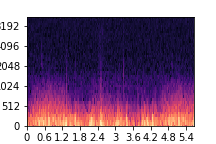

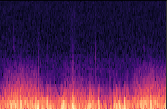

In [ ]:
fig = plt.Figure(figsize=(3, 2))
# fig = plt.Figure() #元々は6,4
canvas = FigureCanvas(fig)
ax = fig.add_subplot(111)
hoge = librosa.display.specshow(train_clips['noise'][77][0].reshape(sample_height, sample_width), ax=ax, y_axis='mel', x_axis='s')
buf = io.BytesIO()
fig.savefig(buf, format='png') 
enc = np.frombuffer(buf.getvalue(), dtype=np.uint8) # bufferからの読み出し
hoge = cv2.imdecode(enc, 1)
print(hoge.shape)
cv2_imshow(hoge)
cv2_imshow(hoge[17:-18, 28:-21, :])
# hoge[35:-35, 54:-43, :]

In [ ]:
test_clips['none'][0]

In [ ]:
def to_spec_img(clips):
  '''
    input: each class clip
    output: new class clip
  '''
  for i in range(len(clips)):
    mel_spect = clips[i][0].reshape(sample_height, sample_width)
    fig = plt.Figure(figsize=(3,2)) #指定しないと(6,4) [35:-35, 54:-43, :]
    canvas = FigureCanvas(fig)
    ax = fig.add_subplot(111)
    hoge = librosa.display.specshow(mel_spect[0:,0:], ax = ax, y_axis='mel', x_axis='s', x_coords=np.arange(0, 5, 5./len(mel_spect[0])))
    buf = io.BytesIO()
    fig.savefig(buf, format='png') 
    enc = np.frombuffer(buf.getvalue(), dtype=np.uint8) # bufferからの読み出し
    hoge = cv2.imdecode(enc, 1) #decode
    X = (hoge[17:-18, 28:-21, :] / 255.0).astype(np.float32)
    # print(f'{X.max()} {X.min()} {X.dtype} {X.shape}')
    new_tuple = (X, clips[i][1], clips[i][2], clips[i][3])  
    clips[i] = new_tuple

In [ ]:
%%time
# fname = "test_noise_img_dict2_rmmargin.dmp"
# target_clips = copy.deepcopy(test_clips['noise'])

# fname = "test_none_img_dict2_rmmargin.dmp"
# target_clips = copy.deepcopy(test_clips['none'])

# fname = "train_noise_img_dict2_rmmargin.dmp"
# target_clips = copy.deepcopy(train_clips['noise'])

fname = "train_none_img_dict2_rmmargin.dmp"
target_clips = copy.deepcopy(train_clips['none'])
to_spec_img(target_clips)
joblib.dump(target_clips,'/content/drive/MyDrive/grad_article/img_dicts/' + fname, compress=3)

CPU times: user 8min 22s, sys: 7.15 s, total: 8min 30s
Wall time: 8min 31s


In [ ]:
load_sample = joblib.load('/content/drive/MyDrive/grad_article/img_dicts/' + fname)
print(f"{len(load_sample)} {load_sample[0][1:]}")

6070 (0, 110, 435)


### data check

In [ ]:
training_clips = sample_dict[0]
test_clips = sample_dict[1]

In [ ]:
def print_sample_count(src_dict):
    print('none:{}\ncrackles:{}\nwheezes:{}\nboth:{}'.format(len(src_dict['none']),
                                                        len(src_dict['crackles']),
                                                        len(src_dict['wheezes']),
                                                        len(src_dict['both'])))

print('Samples Available')
print('[Training set]')
print_sample_count(training_clips)
print('')
print('[Test set]')
print_sample_count(test_clips)

Samples Available
[Training set]
none:6090
crackles:6048
wheezes:7275
both:6824

[Test set]
none:758
crackles:376
wheezes:183
both:106


In [ ]:
training_clips['none'][0][0]

In [ ]:
#Example of tiled sound samples

sample_height = training_clips['none'][0][0].shape[0]
sample_width = training_clips['none'][0][0].shape[1]
ind = 1
plt.figure(figsize = (10,10))
plt.subplot(4,1,1)
plt.imshow(training_clips['none'][ind][0].reshape(sample_height, sample_width))
plt.title('None')
plt.subplot(4,1,2)
plt.imshow(training_clips['crackles'][ind][0].reshape(sample_height, sample_width))
plt.title('Crackles')
plt.subplot(4,1,3)
plt.imshow(training_clips['wheezes'][ind][0].reshape(sample_height, sample_width))
plt.title('Wheezes')
plt.subplot(4,1,4)
plt.imshow(training_clips['both'][ind][0].reshape(sample_height, sample_width))
plt.title('Both')
plt.tight_layout()

### Data Pipeline

In [ ]:
import scipy.signal

#Interleaved sampling between classes
#Used to ensure a balance of classes for the training set
class data_generator():
    #sound_clips = [[none],[crackles],[wheezes],[both]]
    #strides: How far the sampling index for each category is advanced for each step
    def __init__(self, sound_clips, strides):
        self.clips = sound_clips
        self.strides = strides
        self.lengths = [len(arr) for arr in sound_clips]
    
    def n_available_samples(self):
        return int(min(np.divide(self.lengths, self.strides))) * 4
    
    def generate_keras(self, batch_size):
        cursor = [0,0,0,0]
        while True:
            i = 0
            X,y = [],[]
            for c in range(batch_size):
                cat_length = self.lengths[i]
                cat_clips = self.clips[i]
                cat_stride = self.strides[i]
                cat_advance = np.random.randint(low= 1,high = cat_stride + 1)
                clip = cat_clips[(cursor[i] + cat_advance) % cat_length]
                cursor[i] = (cursor[i] + self.strides[i]) % cat_length #advance cursor
                s = (self.rollFFT(clip))
                X.append(s[0])
                y.append(s[1])
                i = (i + 1) % 4 # go to next class
            yield (np.reshape(X, (batch_size, sample_height, sample_width, 1)),
                   np.reshape(y,(batch_size,4)))

    #Transpose and wrap each array along the time axis
    def rollFFT(self, fft_info):
        fft = fft_info[0]
        n_col = fft.shape[1]
        pivot = np.random.randint(n_col)
        return ((np.roll(fft, pivot, axis = 1)), fft_info[1])

#Used for validation set
class feed_all():
    #sound_clips = [[none],[crackles],[wheezes],[both]]
    def __init__(self, sound_clips, roll = True):
        merged = []
        for arr in sound_clips:
            merged.extend(arr)
        np.random.shuffle(merged)
        self.clips = merged
        self.nclips = len(merged)
        self.roll = roll
    
    def n_available_samples(self):
        return len(self.clips)
    
    def generate_keras(self, batch_size):
        i = 0
        while True:
            X,y = [],[]
            for b in range(batch_size):
                clip = self.clips[i]
                i = (i + 1) % self.nclips
                if(self.roll):
                    s = (self.rollFFT(clip))
                    X.append(s[0])
                    y.append(s[1])
                else:
                    X.append(clip[0])
                    y.append(clip[1])
                    
            yield (np.reshape(X, (batch_size,sample_height, sample_width,1)),
                   np.reshape(y,(batch_size, 4)))

    #Transpose and wrap each array along the time axis
    def rollFFT(self, fft_info):
        fft = fft_info[0]
        n_col = fft.shape[1]
        pivot = np.random.randint(n_col)
        return ((np.roll(fft, pivot, axis = 1)), fft_info[1])

In [ ]:
training_clips['none'][0][0]

NameError: ignored

In [ ]:
[none_train, c_train, w_train, c_w_train] = [training_clips['none'], training_clips['crackles'], training_clips['wheezes'], training_clips['both']]
[none_test, c_test, w_test,c_w_test] =  [test_clips['none'], test_clips['crackles'], test_clips['wheezes'], test_clips['both']]

np.random.shuffle(none_train)
np.random.shuffle(c_train)
np.random.shuffle(w_train)
np.random.shuffle(c_w_train)

#Data pipeline objects
train_gen = data_generator([none_train, c_train, w_train, c_w_train], [1,1,1,1])
test_gen = feed_all([none_test, c_test, w_test,c_w_test])

### CNN implementation

In [ ]:
batch_size = 128
n_epochs = 15


In [ ]:
#Keras implementation
from keras import Sequential
from keras import optimizers
from keras import backend as K
from keras.layers import Conv2D, Dense, Activation, Dropout, MaxPool2D, Flatten, LeakyReLU
K.clear_session()

model = Sequential()
model.add(Conv2D(128, [7,11], strides = [2,2], padding = 'SAME', input_shape = (sample_height, sample_width, 1)))
model.add(LeakyReLU(alpha = 0.1))
model.add(MaxPool2D(padding = 'SAME'))

model.add(Conv2D(256, [5,5], padding = 'SAME'))
model.add(LeakyReLU(alpha = 0.1))
model.add(MaxPool2D(padding = 'SAME'))

model.add(Conv2D(256, [1,1], padding = 'SAME'))
model.add(Conv2D(256, [3,3], padding = 'SAME'))
model.add(LeakyReLU(alpha = 0.1))
model.add(MaxPool2D(padding = 'SAME'))

model.add(Conv2D(512, [1,1], padding = 'SAME'))
model.add(Conv2D(512, [3,3], padding = 'SAME',activation = 'relu'))
model.add(Conv2D(512, [1,1], padding = 'SAME'))
model.add(Conv2D(512, [3,3], padding = 'SAME', activation = 'relu'))
model.add(MaxPool2D(padding = 'SAME'))
model.add(Flatten())

model.add(Dense(4096, activation = 'relu'))
model.add(Dropout(0.5))

model.add(Dense(512, activation = 'relu'))
model.add(Dense(4, activation = 'softmax'))

opt = optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.00, amsgrad=False)

model.compile(optimizer =  opt , loss = 'categorical_crossentropy', metrics = ['acc'])

NameError: ignored

In [ ]:
from keras.utils.vis_utils import plot_model

plot_model(model, show_shapes=True, show_layer_names = True)
from IPython.display import Image
Image(filename='model.png')

In [ ]:
stats = model.fit(train_gen.generate_keras(batch_size), 
                            steps_per_epoch = train_gen.n_available_samples() // batch_size,
                            validation_data = test_gen.generate_keras(batch_size),
                            validation_steps = test_gen.n_available_samples() // batch_size, 
                            epochs = n_epochs)

In [ ]:
plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
plt.title('Accuracy')
plt.plot(stats.history['acc'], label = 'training acc')
plt.plot(stats.history['val_acc'], label = 'validation acc')
plt.legend()
plt.subplot(1,2,2)
plt.plot(stats.history['loss'], label = 'training loss')
plt.plot(stats.history['val_loss'], label = 'validation loss')
plt.legend()
plt.title('Loss')

In [ ]:
test_set = test_gen.generate_keras(test_gen.n_available_samples()).__next__()
predictions = model.predict(test_set[0])
predictions = np.argmax(predictions, axis = 1)
labels = np.argmax(test_set[1], axis = 1)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(labels, predictions, target_names = ['none','crackles','wheezes','both']))
print(confusion_matrix(labels, predictions))